In [1]:
# https://github.com/CelestialCartographers/Maple
using Maple, Plots, DataStructures

celestemaps = []
names = []

function displayvalues(name, values)
    println(name)

    n = length(values)
    println("Number of values: ", n)
    if n == 0
        return
    end

    values = sort(values, by = x -> x[2])
    println("Min: ", values[1][2])
    println("Max: ", values[n][2])
    println("Mean: ", sum([value[2] for value in values]) / n)
    println("Median: ", n % 2 == 0 ? (values[div(n,2)][2] + values[div(n,2)+1][2])/2.0 : values[div(n+1,2)][2])

    println("Minimum")
    for (i, (mapindex, value)) in enumerate(values[1:5])
        println(i, ". ", names[mapindex], " ", value)
    end

    println("Maximum")
    for (i, (mapindex, value)) in enumerate(reverse(values[n-4:n]))
        println(i, ". ", names[mapindex], " ", value)
    end

    histogram1 = histogram([value for (_, value) in values], title=name)
    histogram2 = histogram([value for (_, value) in values[floor(Int, 0.05*n):floor(Int, 0.95*n)]], title="Extremes removed")
    plot(histogram1, histogram2, layout=(2, 1))
end

for (root, _, files) in walkdir("Mods")
    for file in files
        if !endswith(file, ".bin")
            continue
        end
        filepath = joinpath(root, file)
        push!(names, filepath)
        push!(celestemaps, loadMap(filepath))
    end
end

numberofmaps = length(celestemaps)
println("Number of maps: ", numberofmaps)

Number of maps: 1137


### Units

The widths, heights and distances use 1 tile height as the unit (1 tile height is about half of Madeline's height).

Empty space and map size use 1 tile area as the unit.

In [2]:
function togrid(value)
    return floor(Int, Float64(value)/8)
end

dimensions = []

for celestemap in celestemaps
    (xmin, ymin, xmax, ymax) = togrid.(Maple.bounds(celestemap))
    push!(dimensions, (xmax - xmin, ymax - ymin))
end

Width
Number of values: 1137
Min: 40
Max: 100243
Mean: 1510.7704485488127
Median: 677
Minimum
1. Mods\150682\Maps\Toto00\FrozenVault\1-FrozenVault-B.bin 40
2. Mods\150751\Maps\pupp\SummitEncore-B.bin 40
3. Mods\150799\Maps\DadbodContests2021\3-Height\Donker19.bin 40
4. Mods\327441\Maps\DecoContest2021\tobyaaa\rewot_suibom.bin 40
5. Mods\328498\Maps\BossSauceMapPack\1-Lobby\TreetopClimb.bin 40
Maximum
1. Mods\332000\Maps\phrog\CreepyCloth\Cloths.bin 100243


2. Mods\150513\Maps\MtEverest\0\MtEverest-D.bin 50164
3. Mods\150759\Maps\nameguysdsidespack\0\10-Farewell.bin 43249
4. Mods\150560\Maps\Thegur90\Solitude\Solitude.bin 42149
5. Mods\150508\Maps\aroxon\Temple\TempleOfMemories.bin 39890

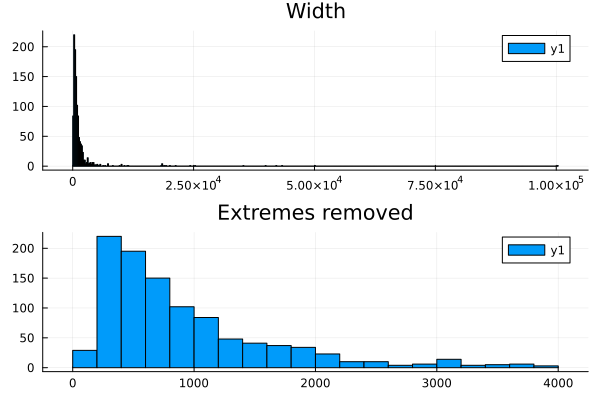

In [3]:
widths = [(index, width) for (index, (width, _)) in enumerate(dimensions)]
displayvalues("Width", widths)

Height
Number of values: 1137
Min: 23
Max: 68128
Mean: 571.3034300791556
Median: 201
Minimum
1. Mods\150404\Maps\ktnzero\zero\desolatevillage.bin 23
2

. Mods\150418\Maps\Dong\0\9Eroc_C.bin 23
3. Mods\150471\Maps\FatherTower\disappointment.bin 23
4. Mods\150487\Maps\vct\leisuretime\cornerbooost.bin 23
5. Mods\150503\Maps\JaThePlayer\MC\MagicCity-C.bin 23
Maximum
1. Mods\351275\Maps\Tardigrade\WaterbearMountain\WaterbearMountain.bin 68128
2. Mods\292719\Maps\Into The Jungle\ch4.bin 22953
3. Mods\150453\Maps\BeefyUncleTorre\map\6.bin 20823
4. Mods\291321\Maps\Escapism\lieutenant\Escapism.bin 20098
5. Mods\150681\Maps\Cabob\FrozenHeights\3-FrostComplex.bin 12705


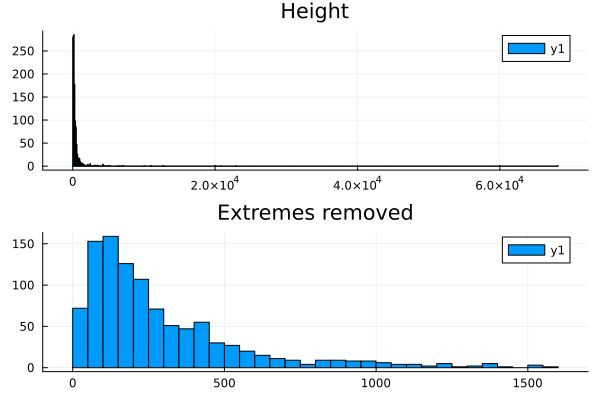

In [4]:
heights = [(index, height) for (index, (_, height)) in enumerate(dimensions)]
displayvalues("Height", heights)

Height to width ratio
Number of values: 1137
Min: 0.006571923414553133
Max: 25.81111111111111
Mean: 0.6281673063764189
Median: 0.30857142857142855
Minimum
1. Mods\150560\Maps\Thegur90\Solitude\Solitude.bin 0.006571923414553133
2. Mods\326785\Maps\EndGameContest2021\1-Submissions\Worldwaker2.bin 0.007661558960692871
3. Mods\303067\Maps\AliceGayWeek\day7.bin 0.009736747205192933
4. Mods\297808\Maps\Toneblock\MentalCollapse\MentalCollapse.bin 0.013411078717201166
5. Mods\150374\Maps\cabobday\oknano\0.bin 0.014404432132963989
Maximum
1. Mods\385401\Maps\tirednwired\CELESTE 2\CELES.bin 25.81111111111111
2. Mods\381885\Maps\OMWU\phant\towerhill.bin 22.9
3. Mods\384870\Maps\ParrotDashBirthdayCollab2022\1-Maps\Volcano.bin 17.125
4. Mods\150759\Maps\nameguysdsidespack\1\2-SummitOldOld-B.bin 15.792307692307693
5. Mods\328498\Maps\BossSauceMapPack\1-Lobby\TreetopClimb.bin 14.425


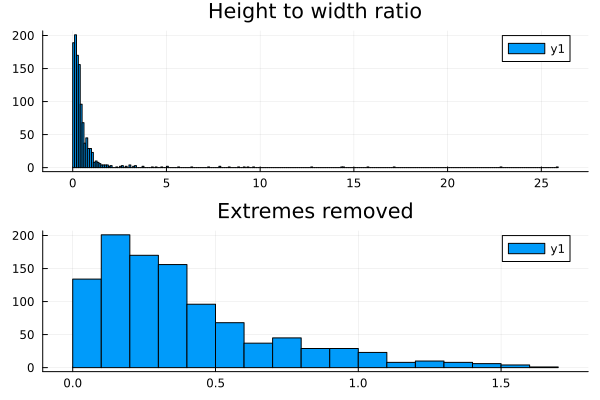

In [5]:
heighttowidthratio = [(index, height / width) for (index, (width, height)) in enumerate(dimensions)]
displayvalues("Height to width ratio", heighttowidthratio)

In [6]:
using Images, SparseArrays

mapsizes = []
emptyspaces = []
playertoendvector = []
bfsdistances = []

SPINNER = -3
PATH = -2
END = -1
FOREGROUND = 0
EMPTY = 1
PLAYER = 2

AIR = '0'

function color(pixel)
    if pixel == END
        return RGB(0.0, 0.0, 1.0)
    elseif pixel == PLAYER
        return RGB(1.0, 0.0, 0.0)
    elseif pixel == PATH
        return RGB(1.0, 0.0, 1.0)
    elseif pixel == FOREGROUND
        return RGB(0.0, 0.0, 0.0)
    elseif pixel == SPINNER
        return RGB(1.0, 1.0, 0.0)
    elseif pixel > PLAYER
        return RGB(0.9, 0.9, 0.9)
    else
        return RGB(1.0, 1.0, 1.0)
    end
end

function drawpath!(grid, bfsclosestend)
    position = bfsclosestend

    while grid[position[1], position[2]] != PLAYER
        nextposition = nothing
        (i, j) = position
        for (a, b) in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
            if 1 <= a && a <= size(grid)[1] && 1 <= b && b <= size(grid)[2]
                visitedduringbfs = grid[a, b] >= PLAYER
                if visitedduringbfs && (nextposition === nothing || grid[nextposition[1], nextposition[2]] > grid[a,b])
                    nextposition = (a, b)
                end
            end
        end
        if grid[i, j] > PLAYER
            grid[i, j] = PATH
        end
        position = nextposition
    end
end

function vectorlength(v)
    return sqrt(v[1]*v[1] + v[2]*v[2])
end

for (index, celestemap) in enumerate(celestemaps)
    (xmin, ymin, xmax, ymax) = togrid.(Maple.bounds(celestemap))

    grid = spzeros(ymax - ymin, xmax - xmin)

    for room in celestemap.rooms
        (x, y) = togrid.(room.position)
        (w, h) = togrid.(room.size)
        grid[y-ymin+1:y+h-ymin, x-xmin+1:x+w-xmin] .= EMPTY
    end
    push!(mapsizes, sum(grid)) # EMPTY = 1 and FOREGROUND = 0

    for room in celestemap.rooms
        (rx, ry) = togrid.(room.position)
        (rw, rh) = togrid.(room.size)
        for entity in room.entities
            if entity isa Spinner
                # Position relative to room, we subtract 1 due to the spinner offset.
                # Spinners have a dimension of 2x2.
                ex = togrid(entity.data["x"]) - 1
                ey = togrid(entity.data["y"]) - 1
                if ex < 0 || ex + 1 >= rw || ey < 0 || ey + 1 >= rh
                    continue
                end

                ex = rx + ex
                ey = ry + ey
                grid[ey-ymin+1:ey-ymin+2, ex-xmin+1:ex-xmin+2] .= SPINNER
            end
        end
    end

    for room in celestemap.rooms
        (x, y) = togrid.(room.position)
        (w, h) = togrid.(room.size)
        for i = 1:h, j = 1:w
            if room.fgTiles.data[i, j] != AIR
                grid[y - ymin + i, x - xmin + j] = FOREGROUND
            end
        end
    end
    emptyspace = 0
    (_, _, nonzerovalues) = findnz(grid)
    for value in nonzerovalues
        if value == EMPTY
            emptyspace += 1
        end
    end
    push!(emptyspaces, emptyspace)

    push!(playertoendvector, nothing)
    push!(bfsdistances, nothing)

    # We choose the room closest to origin and choose the player closest to origin in that room.
    players = []
    for room in celestemap.rooms
        (rx, ry) = togrid.(room.position)
        (rw, rh) = togrid.(room.size)
        for entity in room.entities
            if entity.name == "player"
                # Position relative to room, we subtract 1 and 2 due to the player offset.
                # The player has a dimension 2x2, but we only mark the topleft.
                ex = togrid(entity.data["x"]) - 1
                ey = togrid(entity.data["y"]) - 2
                if ex < 0 || ex >= rw || ey < 0 || ey >= rh
                    continue
                end

                ex = rx + ex
                ey = ry + ey
                push!(players, (vectorlength((rx, ry)), vectorlength((ex, ey)), (ex, ey)))
            end
        end
    end

    player = minimum(players)[3]
    grid[player[2]-ymin+1, player[1]-xmin+1] = PLAYER

    # We first look for a trigger in the rooms to end the level.
    # If it doesn't exist, we look for a heart in the rooms.
    # If it doesn't exist, we don't need to perform BFS.
    for room in celestemap.rooms
        (rx, ry) = togrid.(room.position)
        (rw, rh) = togrid.(room.size)
        for trigger in room.triggers
            if trigger isa EverestCompleteAreaTrigger || trigger isa EverestDialogTrigger && get(trigger.data, "endLevel", false)
                tx = togrid(trigger.data["x"])
                ty = togrid(trigger.data["y"])
                tw = togrid(trigger.data["width"])
                th = togrid(trigger.data["height"])
                for i = 0:(tw-1), j = 0:(th-1)
                    if 0 <= tx + i && tx + i < rw && 0 <= ty + j && ty + j < rh && grid[ry + ty + j - ymin + 1, rx + tx + i - xmin + 1] == EMPTY
                        grid[ry + ty + j - ymin + 1, rx + tx + i - xmin + 1] = END
                        playertoend = (rx + tx + i - player[1], ry + ty + j - player[2])
                        if playertoendvector[index] === nothing || vectorlength(playertoend) < vectorlength(playertoendvector[index])
                            playertoendvector[index] = playertoend
                        end
                    end
                end
            end
        end
    end
    if playertoendvector[index] === nothing
        for room in celestemap.rooms
            for entity in room.entities
                if contains(lowercase(entity.name), "heart") || entity.name == "blackGem"
                    (rx, ry) = togrid.(room.position)
                    (rw, rh) = togrid.(room.size)
                    ex = togrid(entity.data["x"])
                    ey = togrid(entity.data["y"])
                    if 0 <= ex && ex < rw && 0 <= ey && ey < rh
                        ex = rx + ex
                        ey = ry + ey
                        grid[ey-ymin+1, ex-xmin+1] = END
                        playertoend = (ex - player[1], ey - player[2])
                        if playertoendvector[index] === nothing || vectorlength(playertoend) < vectorlength(playertoendvector[index])
                            playertoendvector[index] = playertoend
                        end
                    end
                end
            end
        end
        if playertoendvector[index] === nothing
            continue
        end
    end

    bfsclosestend = nothing
    # https://stackoverflow.com/a/48647865
    bfsqueue = Deque{Tuple{Int, Int}}()
    push!(bfsqueue, (player[2]-ymin+1, player[1]-xmin+1))

    while !isempty(bfsqueue) && bfsclosestend === nothing
        (i, j) = popfirst!(bfsqueue)
        for (a, b) in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
            if 1 <= a && a <= size(grid)[1] && 1 <= b && b <= size(grid)[2]
                if grid[a, b] == END
                    bfsclosestend = (a, b)
                    bfsdistances[index] = grid[i, j] - PLAYER + 1
                    break
                elseif grid[a, b] == EMPTY
                    grid[a, b] = grid[i, j] + 1
                    push!(bfsqueue, (a, b))
                end
            end
        end
    end

    if bfsclosestend !== nothing
        position = bfsclosestend

        while grid[position[1], position[2]] != PLAYER
            nextposition = nothing
            (i, j) = position
            for (a, b) in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
                if 1 <= a && a <= size(grid)[1] && 1 <= b && b <= size(grid)[2]
                    visitedduringbfs = grid[a, b] >= PLAYER
                    if visitedduringbfs && (nextposition === nothing || grid[nextposition[1], nextposition[2]] > grid[a,b])
                        nextposition = (a, b)
                    end
                end
            end
            if grid[i, j] > PLAYER
                grid[i, j] = PATH
            end
            position = nextposition
        end
    end
end

Map size
Number of values: 1137
Min: 920.0
Max: 2.761018e6
Mean: 77096.46613896218
Median: 37474.0
Minimum
1. Mods\150682\Maps\Toto00\FrozenVault\1-FrozenVault-B.bin 920.0
2. Mods\150751\Maps\pupp\SummitEncore-B.bin 920.0
3. Mods\361990\Maps\firstmap\knk\knkfirstmap-B.bin 1840.0
4. Mods\370683\Maps\Rainier\0-Lobbies\1-Rainier.bin 2001.0
5. Mods\326785\Maps\EndGameContest2021\1-Submissions\tobyaaa.bin 2093.0
Maximum
1. Mods\150759\Maps\nameguysdsidespack\0\10-Farewell.bin 2.761018e6
2. Mods\150759\Maps\nameguysdsidespack\1\6-FinalGoodbyeOld.bin 1.676695e6
3. Mods\351275\Maps\Tardigrade\WaterbearMountain\WaterbearMountain.bin 938224.0
4. Mods\359894\Maps\DarkLeviathan82\LeviathansRehearsal\LeviathansRehearsal.bin 926321.0
5. Mods\286934\Maps\math\D1D7\D1D7.bin 780492.0

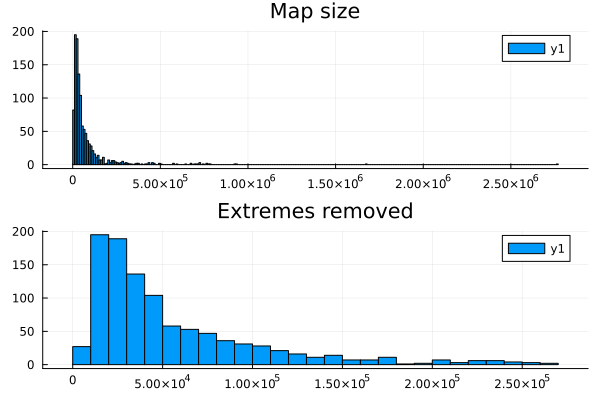

In [7]:
mapsizeandindex = [x for x in enumerate(mapsizes)]
displayvalues("Map size", mapsizeandindex)

Empty space in map
Number of values: 1137
Min: 760
Max: 2211975
Mean: 52896.93227792436
Median: 21874
Minimum
1. Mods\150682\Maps\Toto00\FrozenVault\1-FrozenVault-B.bin 760
2. Mods\150751\Maps\pupp\SummitEncore-B.bin 880
3. Mods\361990\Maps\firstmap\knk\knkfirstmap-B.bin 936
4. Mods\326007\Maps\CelestialCabinet\ABuffZucchini\CelestialCabinet-C.bin 1248
5. Mods\316601\Maps\Nyan\BDAYLEAFY.bin 1346
Maximum
1. Mods\150759\Maps\nameguysdsidespack\0\10-Farewell.bin 2211975
2. Mods\150759\Maps\nameguysdsidespack\1\6-FinalGoodbyeOld.bin 1306997
3. Mods\359894\Maps\DarkLeviathan82\LeviathansRehearsal\LeviathansRehearsal.bin 790221
4. Mods\351275\Maps\Tardigrade\WaterbearMountain\WaterbearMountain.bin 755177
5. Mods\150426\Maps\monikafarewellbuffededition\0\1-FarewellBuffed.bin 664709


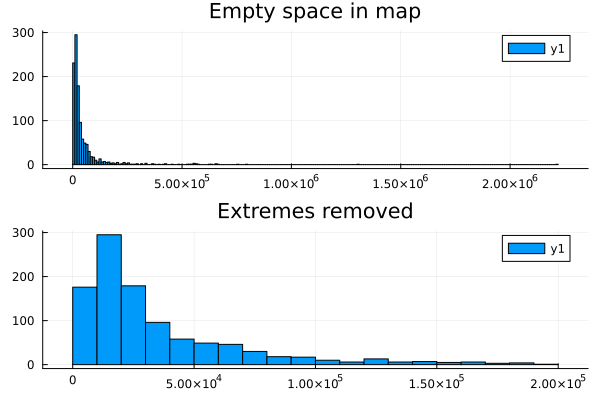

In [8]:
emptyspaceandindex = [x for x in enumerate(emptyspaces)]
displayvalues("Empty space in map", emptyspaceandindex)

Empty space to map size ratio
Number of values: 1137
Min: 0.17044224668781488
Max: 0.9998932251348033
Mean: 0.6314681319690556
Median: 0.6290569503980404
Minimum
1. Mods\326785\Maps\EndGameContest2021\1-Submissions\Quinnigan.bin 0.17044224668781488
2. Mods\364346\Maps\Triangles\SmallGarden\SmallGarden.bin 0.17325174825174824
3. Mods\368327\Maps\CombRoomCollab\0-Lobbies\lobby.bin 0.20570982491357198
4. Mods\326007\Maps\CelestialCabinet\ABuffZucchini\CelestialCabinet.bin 0.21493788819875775
5. Mods\376976\Maps\MOCE_CPCL\issy\MOCE_CPCL.bin 0.21583850931677018
Maximum
1. Mods\372434\Maps\Musicworldcontest\musicworld\abyss.bin 0.9998932251348033
2. Mods\341492\Maps\BallsTourney2021\1-Main\hennyburgr.bin 0.998959958398336
3. Mods\150813\Maps\SpringCollab2020\5-Grandmaster\BobDole.bin 0.9846907216494846
4. Mods\384870\Maps\ParrotDashBirthdayCollab2022\1-Maps\asgordcomplex.bin 0.9843643448611787
5. Mods\150813\Maps\SpringCollab2020\2-Intermediate\Thegur90.bin 0.9775558725630052


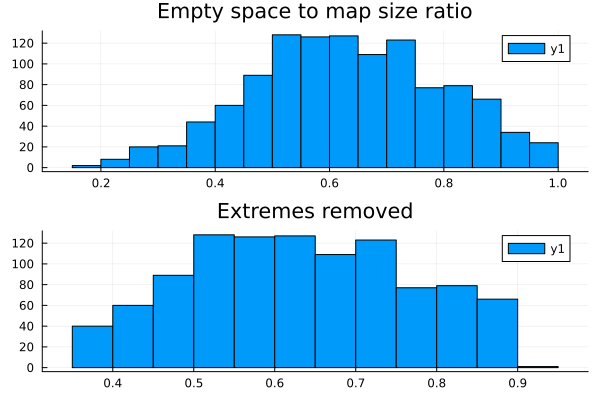

In [9]:
emptyspacetomapsizeratio = [(i, emptyspaces[i]/mapsizes[i]) for i in 1:numberofmaps]
displayvalues("Empty space to map size ratio", emptyspacetomapsizeratio)

Number of maps with ends: 1104


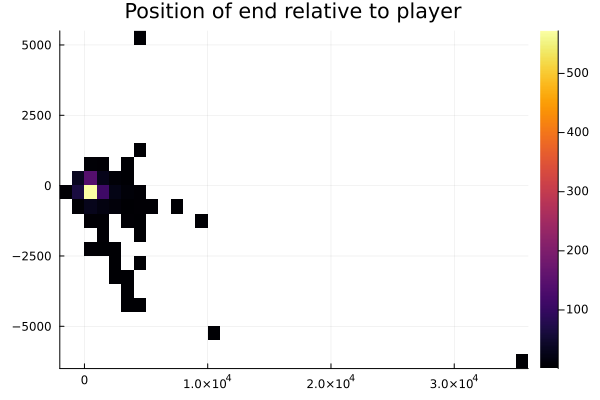

In [10]:
x = [v[1] for v in playertoendvector if v !== nothing]
y = [v[2] for v in playertoendvector if v !== nothing]
println("Number of maps with ends: ", length(x))
histogram2d(x, y, title="Position of end relative to player", bins=(50, 50))

BFS distance from player to end
Number of values: 828
Min: 5.0
Max: 8958.0
Mean: 989.6231884057971
Median: 739.5
Minimum
1. Mods\344018\Maps\Eeveeisepic\DadBodBirthday\DadBodBirthday.bin 5.0
2. Mods\368514\Maps\Soloiini\Array\array.bin 5.0
3. Mods\381957\Maps\MysteryBoxContest2022\0-Lobbies\1-Maps.bin 9.0
4. Mods\150813\Maps\SpringCollab2020\0-Lobbies\3-Advanced.bin 12.0
5. Mods\378189\Maps\alicequasar\lavamap\lva.bin 13.0
Maximum
1. Mods\150562\Maps\SpacePeak\0\SpacePeak.bin 8958.0
2. Mods\150759\Maps\nameguysdsidespack\0\6-ReflectionD.bin 8500.0
3. Mods\150574\Maps\doublejump\A.bin 7879.0
4. Mods\377957\Maps\Phobs\PSides\7-Summitdside.bin 6717.0
5. Mods\150491\Maps\tom\0\2-city.bin 5927.0


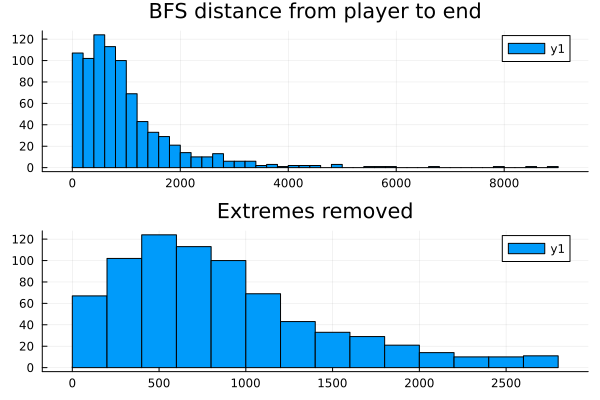

In [11]:
bfsdistanceandindex = [(i, distance) for (i, distance) in enumerate(bfsdistances) if distance !== nothing]
displayvalues("BFS distance from player to end", bfsdistanceandindex)

BFS distance to player-end distance ratio
Number of values: 828
Min: 1.0
Max: 49.0293329179719
Mean: 1.7443661599470919
Median: 1.3467599786614395
Minimum
1. Mods\150418\Maps\Dong\0\7TimmusEht.bin 1.0
2. Mods\150418\Maps\Dong\0\7TimmusEht_B.bin 1.0
3. Mods\150418\Maps\Dong\0\9Eroc_C.bin 1.0
4. Mods\368514\Maps\Soloiini\Array\array.bin 1.0
5. Mods\150800\Maps\NewYearsContest2021\1-Submissions\tobyaaa.bin 1.0034482450222268
Maximum
1. Mods\382667\Maps\ElectionD\Jan\ElectionD.bin 49.0293329179719
2. Mods\329903\Maps\StartupContest2021\1-Submissions\abuffzucchini.bin 26.528941097417235
3. Mods\150813\Maps\SpringCollab2020\2-Intermediate\Lichtbaulb.bin 24.00014367773085
4. Mods\150741\Maps\Romka\Small sanctuary+\Small sanctuary.bin 15.10215298158414
5. Mods\150778\Maps\CANADIAN\map\00_UltraHell.bin 14.641709757607934


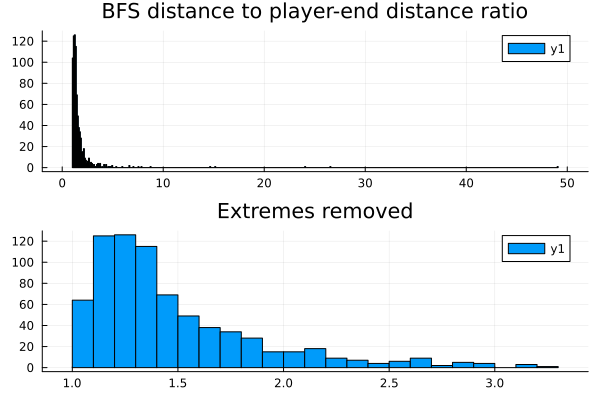

In [12]:
distanceratio = [(i, bfsdistances[i]/vectorlength(playertoendvector[i])) for i in 1:numberofmaps if bfsdistances[i] !== nothing]
displayvalues("BFS distance to player-end distance ratio", distanceratio)